In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

In [3]:
from sklearn.metrics import f1_score, confusion_matrix, multilabel_confusion_matrix

In [4]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Accuracy

In [5]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, 
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.8.0
keras version 2.8.0
Eager Execution Enabled: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
sns.set_palette('pastel')

In [7]:
hnm_file_format = '/content/drive/MyDrive/Temporary/CS25_Project/HnM_{}.parquet'
hnm_img_format = '/content/drive/MyDrive/Temporary/CS25_Project/images/HnM/{}'

In [8]:
# folder names
hnm_img_final = '/content/drive/MyDrive/Temporary/CS25_Project/images_final/HnM/'
hnm_img_final_top = '/content/drive/MyDrive/Temporary/CS25_Project/images_final'

In [9]:
model_wts_path = '/content/drive/MyDrive/Temporary/CS25_Project/'
model_hist_path = '/content/drive/MyDrive/Temporary/CS25_Project/'

In [10]:
models = {
    'Resnet50': {
        'model': 'ResNet50',
        'preprocess': 'resnet50',
    },
    'VGG19': {
        'model': 'VGG19',
        'preprocess': 'vgg19',
    },
    'InceptionV3': {
        'model': 'InceptionV3',
        'preprocess': 'inception_v3',
    },
    'MobileNetV2': {
        'model': 'MobileNetV2',
        'preprocess': 'mobilenet_v2',
    },
    'EfficientNetB3': {
        'model': 'EfficientNetB3',
        'preprocess': 'efficientnet',
    },
}

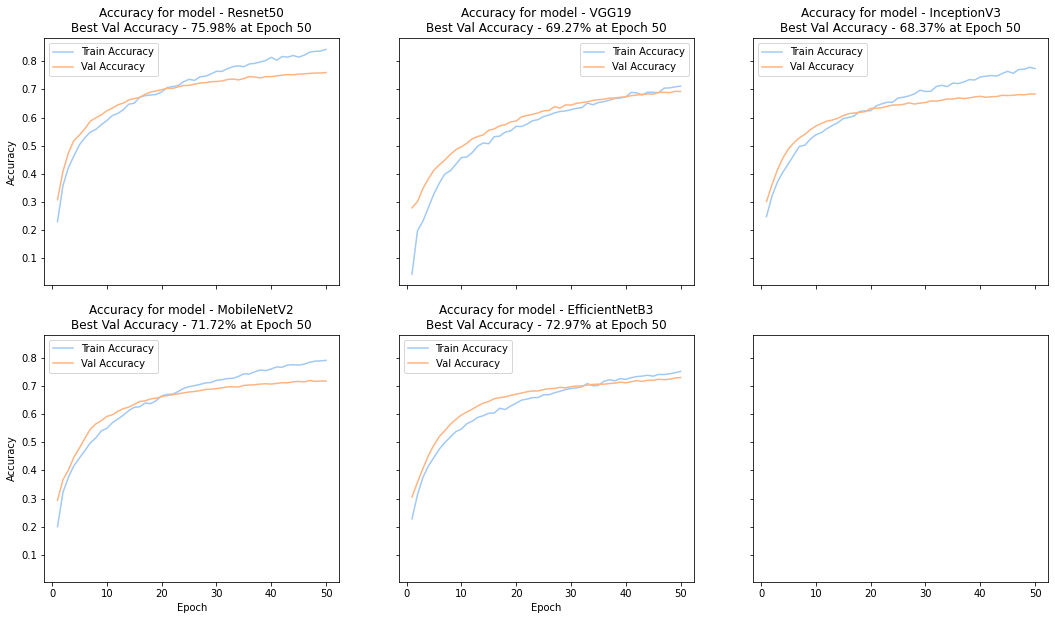

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True, sharey=True)
axes = axes.ravel()

for idx, model in enumerate(models.keys()):
    with open(f"{model_hist_path}{model}.pkl", 'rb') as file_pi:
        hist = pickle.load(file_pi)

    best_epoch = np.argmin(hist['val_loss'])

    sns.lineplot(x=range(1, len(hist['val_accuracy']) + 1 ), y=hist['accuracy'], ax=axes[idx], label='Train Accuracy')
    sns.lineplot(x=range(1, len(hist['val_accuracy']) + 1 ), y=hist['val_accuracy'], ax=axes[idx], label='Val Accuracy')

    axes[idx].set(
        title=f"Accuracy for model - {model}\nBest Val Accuracy - {hist['val_accuracy'][best_epoch]:.2%} at Epoch {best_epoch+1}",
        xlabel="Epoch",
        ylabel="Accuracy"
    )

    # axes[idx].axvline(x=best_epoch+1, color='red')

plt.show()

### Best model: Resnet50
Continuing with assessment of predictions based on this model

In [12]:
## load the data frame
df = pd.read_parquet(hnm_file_format.format('Final_Input_Df'))
df['Category_Name'] = df['Category_Name'].astype('category')
df['Category_Name_Code'] = df['Category_Name'].cat.codes

In [13]:
# sort by the code since thats how flow from directory would work
df = df.sort_values(by='Code')
df.head()

,Code,Name,Img_Ext,Parent_Category,Top_Category,Parent_Category_Name,Category_Name,Category_Name_Code
9842,0107727001,Bademantel aus Leinen,.jpg,18.0,Women,Nachtwäsche,Women_Nachtwäsche,23
9844,0107727002,Bademantel aus Leinen,.jpg,18.0,Women,Nachtwäsche,Women_Nachtwäsche,23
9839,0107727021,Bademantel aus Leinen,.jpg,18.0,Women,Nachtwäsche,Women_Nachtwäsche,23
9832,0107727061,Bademantel aus Leinen,.jpg,18.0,Women,Nachtwäsche,Women_Nachtwäsche,23
9837,0107727062,Bademantel aus Leinen,.jpg,18.0,Women,Nachtwäsche,Women_Nachtwäsche,23


In [14]:
y_train = df['Category_Name_Code'].values
nr_labels = len(np.unique(y_train))

In [15]:
df[['Category_Name', 'Category_Name_Code']].drop_duplicates().sort_values(by='Category_Name_Code')

,Category_Name,Category_Name_Code
16742,Baby_Accessoires,0
16070,Baby_Kleidung,1
22389,Kids_Accessoires,2
21636,Kids_Kleidung,3
22022,Kids_Outdoor,4
22627,Kids_Schuhe,5
14103,Men_Accessoires,6
12358,Men_Cardigans-&-Pullover,7
12489,Men_Hemden,8
12158,Men_Hoodies-&-Sweatshirts,9


In [16]:
random_seed = 109
input_shape = (256, 256, 3)

images_test = image_dataset_from_directory(
    hnm_img_final_top,
    labels = list(y_train),
    seed = random_seed,
    batch_size=256,
    shuffle=False,
    image_size=input_shape[:2]
)


Found 14456 files belonging to 1 classes.


In [17]:
# instantiate the model and load the weights
model_name = 'Resnet50'
final_model = models[model_name]

inputs = tf.keras.layers.Input(shape=input_shape)
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
base_model = eval('tf.keras.applications.' + final_model['model'])(include_top=False, input_shape=input_shape, pooling='avg')
# x = base_model(inputs, training=False)
x = base_model.output
# x = base_model.get_layer('avg_pool').output
# x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
# and a logistic layer -- with classes = nr_labels
predictions = Dense(nr_labels, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.load_weights(f"{model_wts_path}{model_name}.h5")

94781440/94765736 [==============================] - 0s 0us/step


In [18]:
images_test_f = images_test.map(lambda x, y: ( eval('tf.keras.applications.resnet50.preprocess_input')(x), y ), num_parallel_calls=AUTOTUNE)
images_test_f = images_test_f.prefetch(1)

In [20]:
# for img, label in images_test_f.take(1):
#     break

In [21]:
# label

In [19]:
probs = model.predict(images_test_f, verbose=1)

57/57 [==============================] - 298s 2s/step


In [23]:
# [np.argmax(p) for p in probs]

In [20]:
y_preds = np.array([np.argmax(p) for p in probs])

In [21]:
scores = f1_score(y_train, y_preds, average=None)

In [22]:
df_cats = df[['Category_Name', 'Category_Name_Code']].drop_duplicates().sort_values(by='Category_Name_Code')

In [48]:
scores_df = pd.DataFrame({
    'Category_Code': df_cats['Category_Name_Code'].values,
    'Category': df_cats['Category_Name'].values,
    'Cnt_Products': df.groupby('Category_Name_Code')['Code'].nunique().sort_index().values,
    'F1_Score': scores
}).sort_values('F1_Score')

scores_df.head(10).style.format({'Cnt_Products': "{:,}".format, 'F1_Score': "{:.1%}".format})

,Category_Code,Category,Cnt_Products,F1_Score
29,29,Women_Sportbekleidung,256,41.1%
11,11,Men_Schuhe,124,63.4%
6,6,Men_Accessoires,271,65.0%
26,26,Women_Shirts-&-Tops,568,67.0%
2,2,Kids_Accessoires,286,68.5%
7,7,Men_Cardigans-&-Pullover,130,68.5%
16,16,Women_Cardigans-&-Pullover,281,68.5%
23,23,Women_Nachtwäsche,260,69.9%
27,27,Women_Shorts,215,72.7%
12,12,Men_T-Shirts,244,73.5%


In [40]:
df['Y_Pred'] = y_preds

In [43]:
df[(df['Category_Name_Code'] == 7) & (df['Category_Name_Code'] != df['Y_Pred'])].head()

,Code,Name,Img_Ext,Parent_Category,Top_Category,Parent_Category_Name,Category_Name,Category_Name_Code,Y_Pred
12366,0564358059,Feinstrickpullover aus Baumwolle Slim Fit,.jpg,227.0,Men,Cardigans & Pullover,Men_Cardigans-&-Pullover,7,9
12342,0673281036,Cardigan mit Reißverschluss,.jpg,227.0,Men,Cardigans & Pullover,Men_Cardigans-&-Pullover,7,16
12345,0673281040,Cardigan mit Reißverschluss,.jpg,227.0,Men,Cardigans & Pullover,Men_Cardigans-&-Pullover,7,9
12348,0673281041,Cardigan mit Reißverschluss,.jpg,227.0,Men,Cardigans & Pullover,Men_Cardigans-&-Pullover,7,9
12349,0673281045,Cardigan mit Reißverschluss,.jpg,227.0,Men,Cardigans & Pullover,Men_Cardigans-&-Pullover,7,9


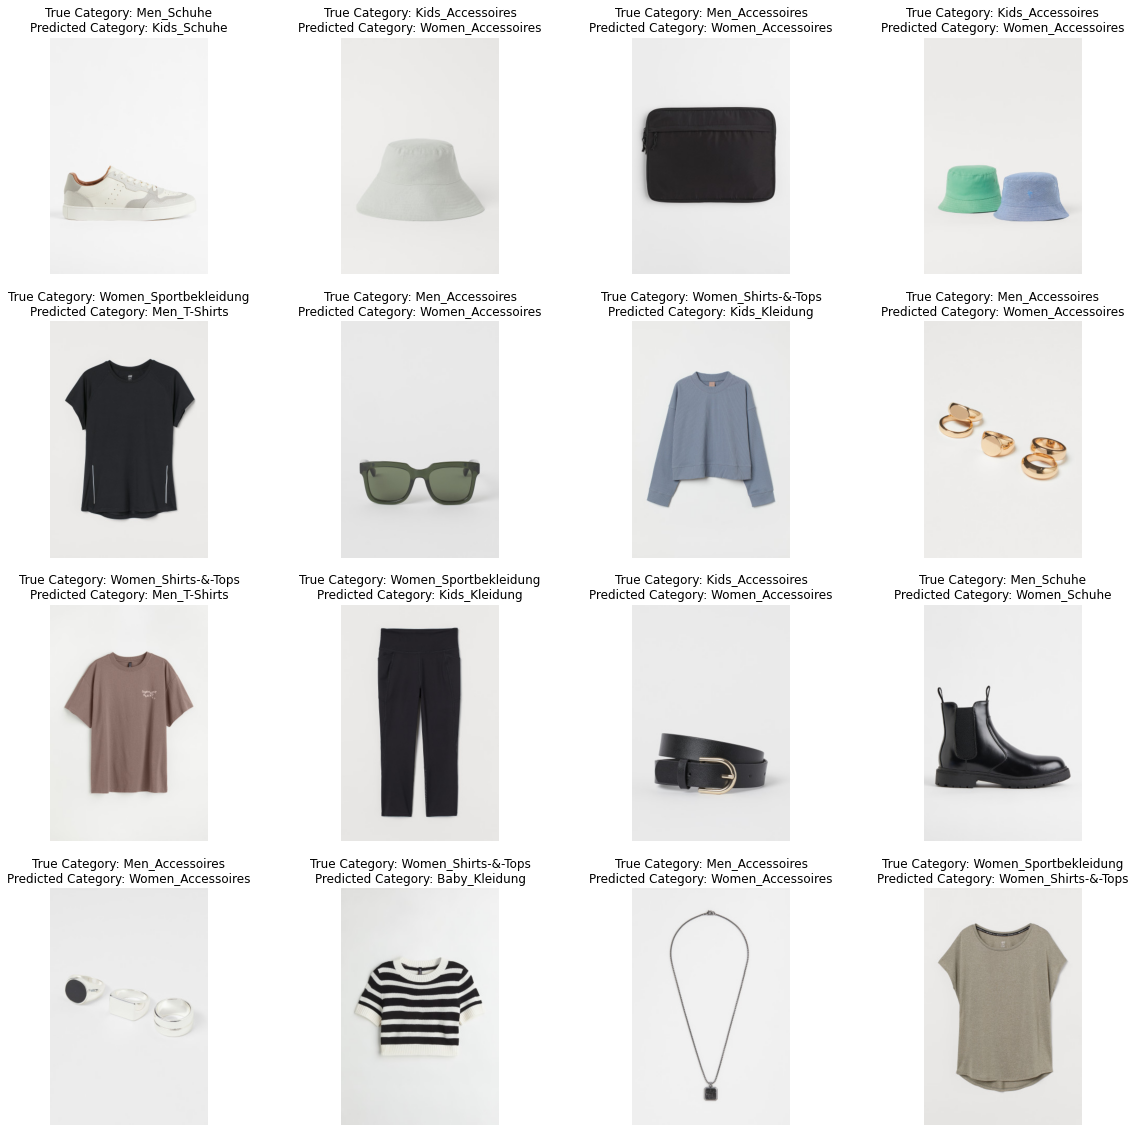

In [68]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
axes = axes.ravel()

worst_cats = scores_df.iloc[:5]['Category_Code'].values

for ax in axes:
    # get a random image from the top 5 worst performing categories
    s = df[(df['Category_Name_Code'].isin(worst_cats)) & (df['Category_Name_Code'] != df['Y_Pred'])].sample()
    ax.imshow(plt.imread(hnm_img_final + s.iloc[0]['Code'] + s.iloc[0]['Img_Ext']))
    ax.set(
        title=f"True Category: {df_cats.iloc[s.iloc[0]['Category_Name_Code']]['Category_Name']}\nPredicted Category: {df_cats.iloc[s.iloc[0]['Y_Pred']]['Category_Name']}"
    )
    ax.axis('off')

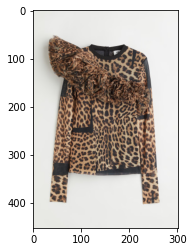

In [101]:
s = df[(df['Category_Name_Code'].isin(worst_cats)) & (df['Category_Name_Code'] != df['Y_Pred'])].reset_index().sample()
plt.imshow(plt.imread(hnm_img_final + s.iloc[0]['Code'] + s.iloc[0]['Img_Ext']))

In [102]:
s

,index,Code,Name,Img_Ext,Parent_Category,Top_Category,Parent_Category_Name,Category_Name,Category_Name_Code,Y_Pred
567,626,1053118001,Meshshirt mit Volant,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops,26,3


In [103]:
pd.DataFrame({
    'Category': df_cats['Category_Name'].values,
    'Probability': probs[s.iloc[0].name]
}).sort_values(by='Probability', ascending=False).head().style.format({'Probability': '{:.1%}'.format})

,Category,Probability
28,Women_Socken-&-Strumpfhosen,85.2%
1,Baby_Kleidung,9.1%
13,Women_Accessoires,2.8%
3,Kids_Kleidung,0.9%
0,Baby_Accessoires,0.8%


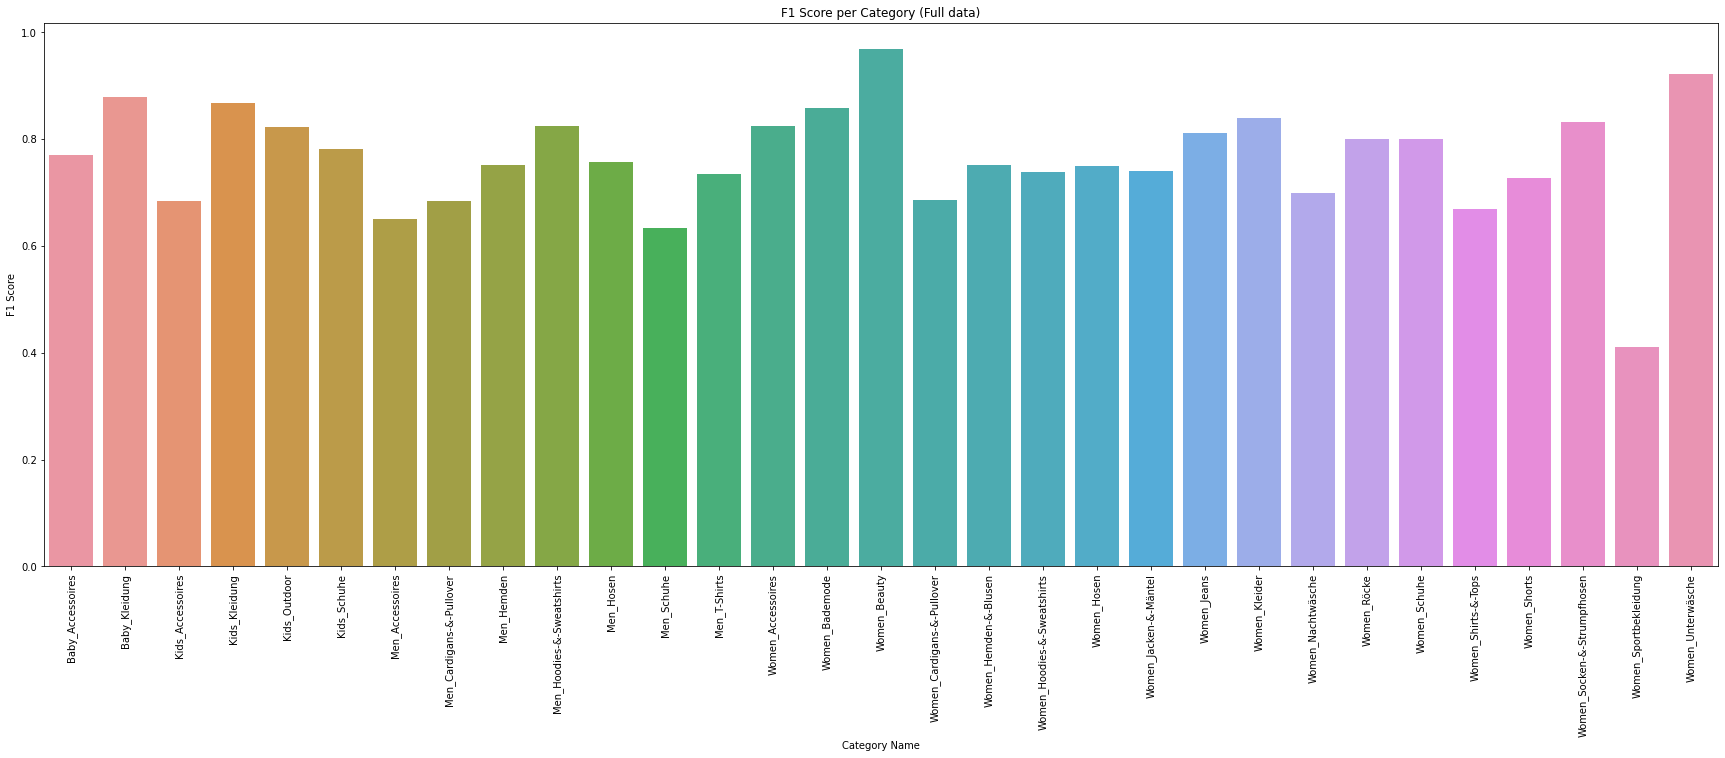

In [23]:
fig, axes = plt.subplots(1, 1, figsize=(30, 10))

sns.barplot(x=df_cats['Category_Name'].values, y=scores, ax=axes)

axes.set(
    title='F1 Score per Category (Full data)',
    xlabel='Category Name',
    ylabel='F1 Score'
)

plt.xticks(rotation = 90)

plt.show()

In [72]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
        group_percentages = ["{0:.2%}".format(value) for value in np.divide(cf_matrix, np.sum(cf_matrix, axis=1)).flatten()]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [60]:
cf_matrix = confusion_matrix(y_train, y_preds)

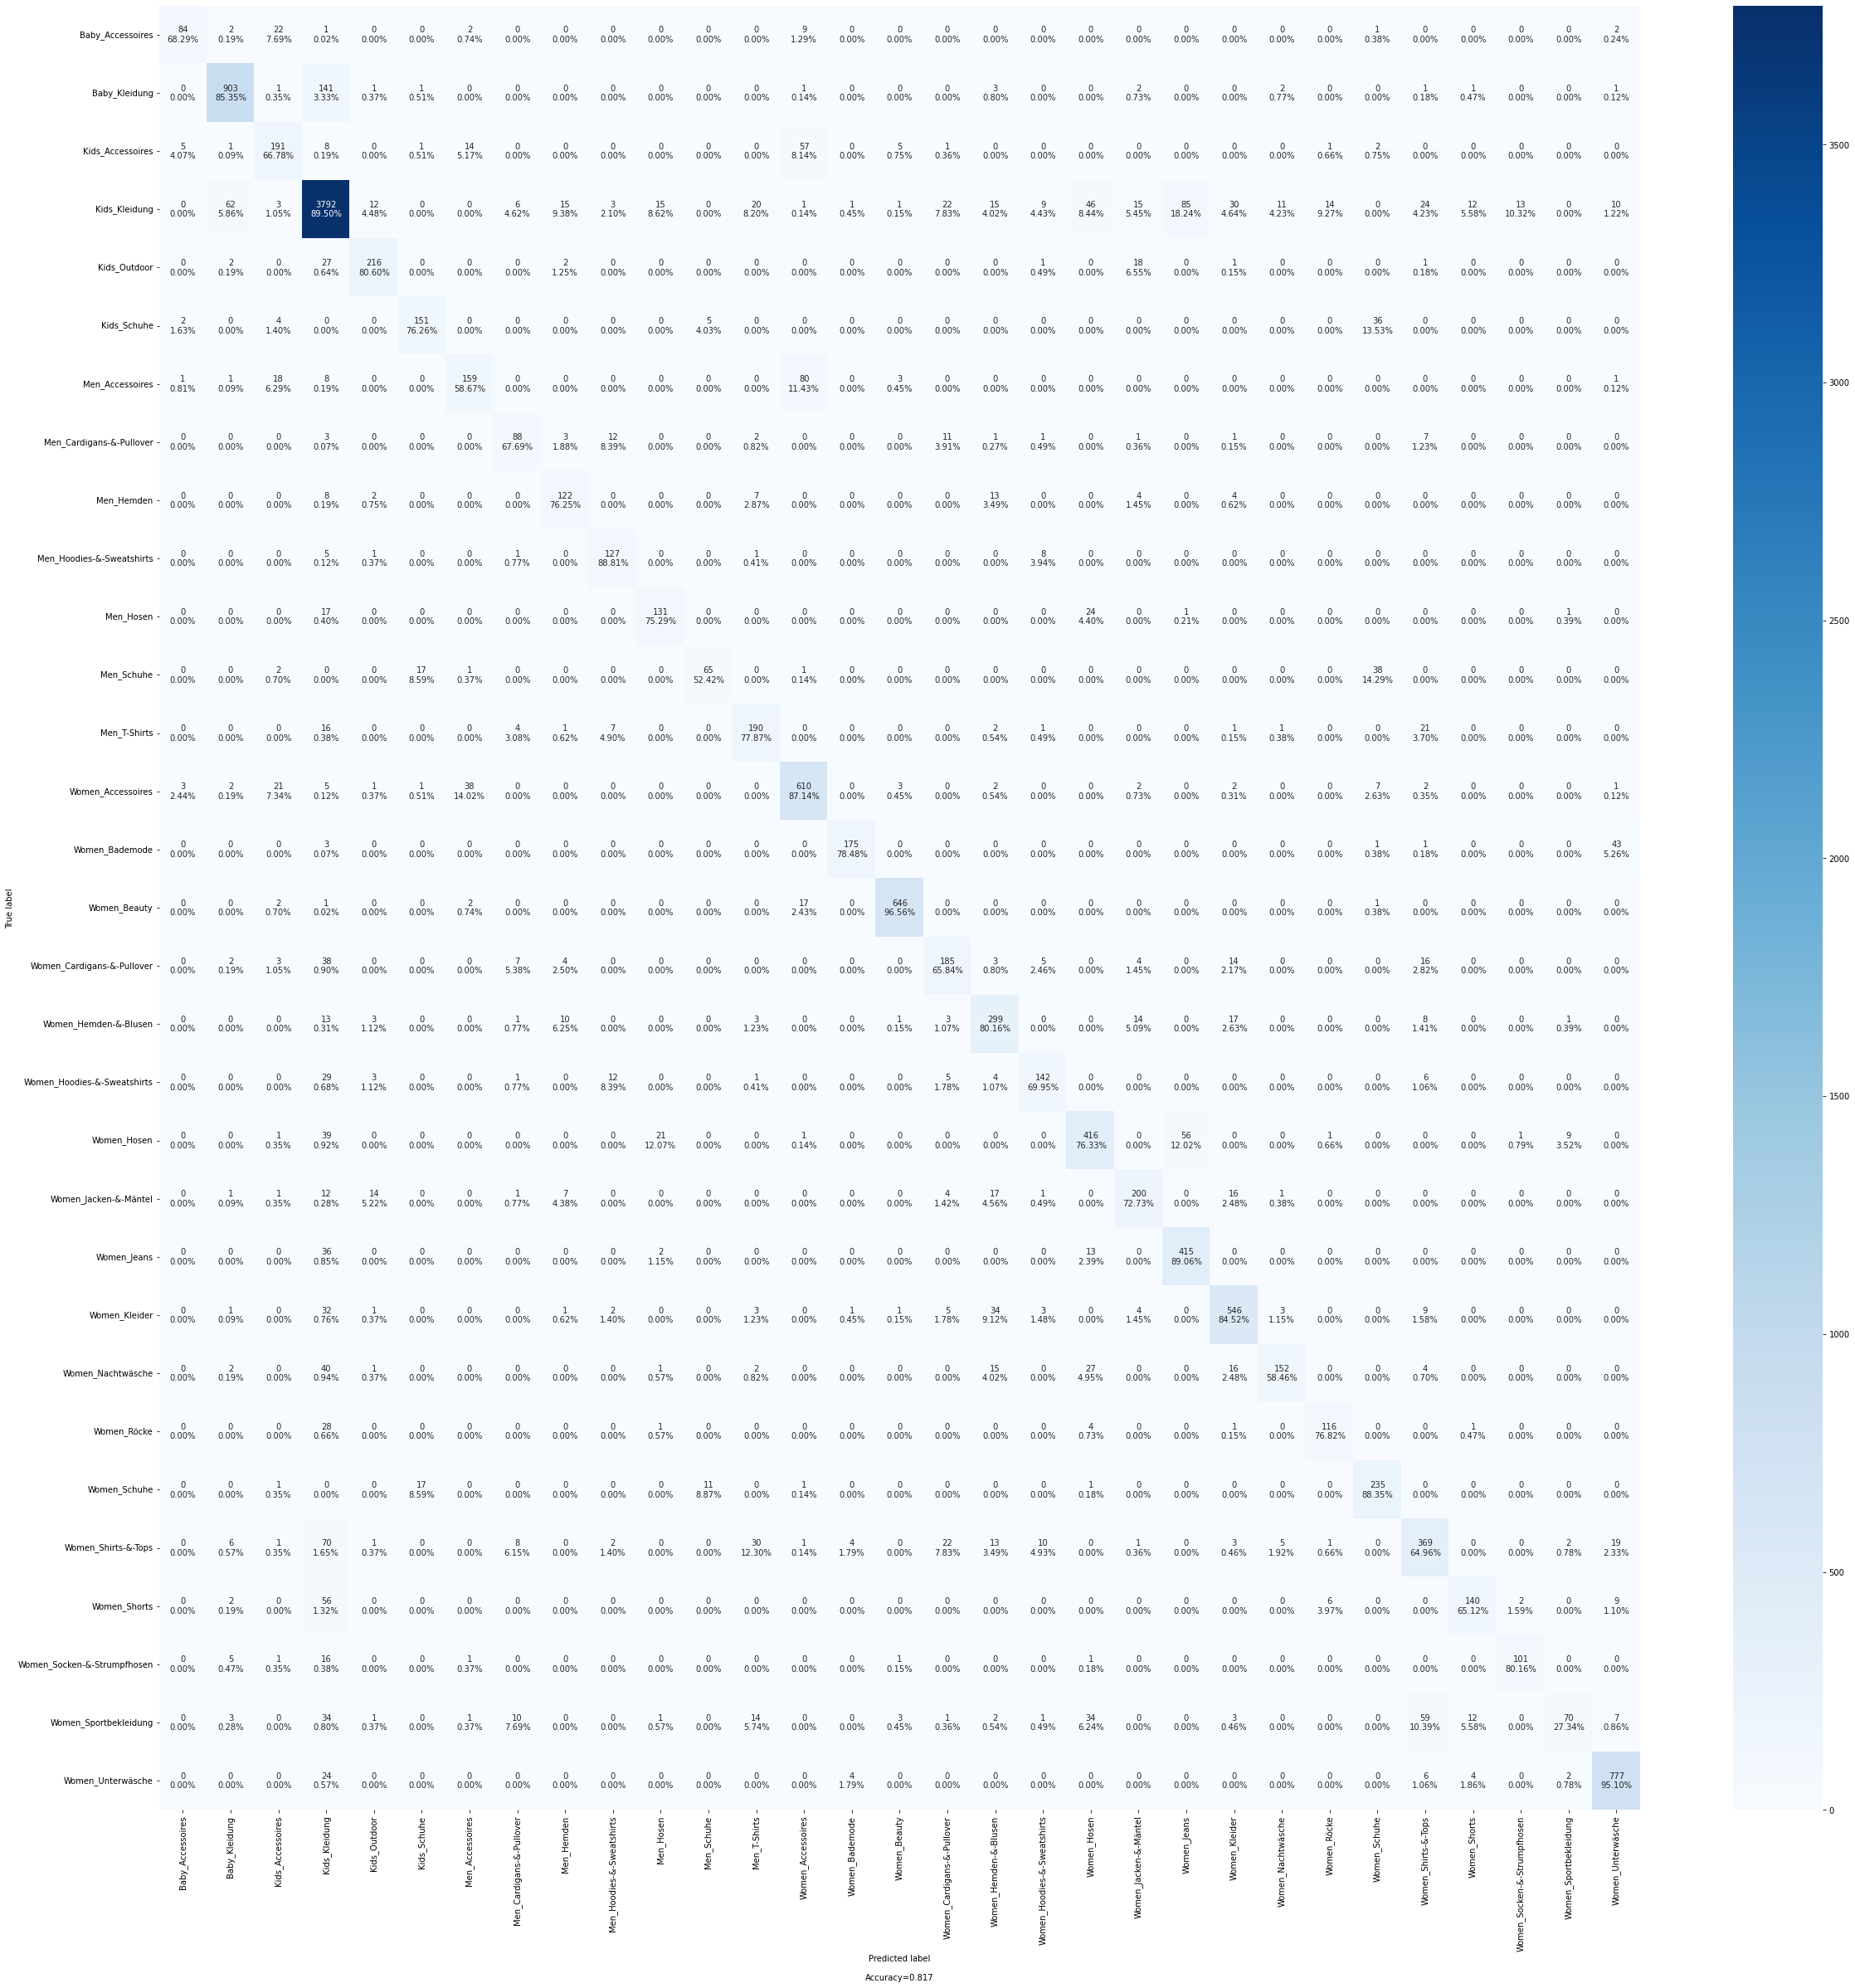

In [73]:
make_confusion_matrix(
    confusion_matrix(y_train, y_preds), 
    figsize=(40, 40),
    categories = df_cats['Category_Name'].values,
)